In [2]:
import torch
import pandas
import numpy as np
from pipeline.diffprep_fix_pipeline import DiffPrepFixPipeline
from pipeline.diffprep_flex_pipeline import DiffPrepFlexPipeline
from prep_space import space
from experiment.experiment_utils import set_random_seed, load_data, build_data, grid_search, makedir, save_result, load_data_multitask

In [3]:
def load_prep_pipeline(path, prep_space, params, data_dir, dataset):

    X, y = load_data_multitask(data_dir, dataset)
    X_train, y_train, X_val, y_val, X_test, y_test = build_data(X, y, random_state=params["split_seed"])

    prep_pipeline = DiffPrepFixPipeline(prep_space, temperature=params["temperature"],
                                use_sample=params["sample"],
                                diff_method=params["diff_method"],
                                init_method=params["init_method"])
    prep_pipeline.init_parameters(X_train, X_val, X_test)
    prep_pipeline.load_state_dict(torch.load(path))
    #prep_pipeline.eval()

    return prep_pipeline

In [4]:
# define hyper parameters
params = {
    "num_epochs": 2000,
    "batch_size": 512,
    "device": "cpu",
    #"model_lr": [0.1, 0.01, 0.001],
    "model_lr": 0.01,
    "weight_decay": 0,
    "model": 'log',
    "train_seed": 1,
    "split_seed": 1,
    "method": "diffprep_fix",
    "save_model": True,
    "logging": False,
    "no_crash": False,
    "patience": 3,
    "momentum": 0.9
}

auto_prep_params = {
    "prep_lr": None,
    "temperature": 0.1,
    "grad_clip": None,
    "pipeline_update_sample_size": 512,
    "init_method": "default",
    "diff_method": "num_diff",
    "sample": False
}

params.update(auto_prep_params)

DATADIR = "data"
dataset = "Airbnb"


In [12]:
prep_pipeline_rating = load_prep_pipeline('./result/diffprep_fix/Airbnb/Rating_ground_truth/prep_pipeline.pth', space, params, DATADIR, dataset)

In [15]:
sim = 0.5


In [16]:
import torch.nn.functional as F

In [23]:
rating_pipeline_params = prep_pipeline_rating.state_dict()

In [24]:
def get_pipeline_ops(prep_pipeline_params):
    pipeline_ops = {}
    for pipeline_step, pipeline in prep_pipeline_params.items():
        #print(pipeline_step, pipeline.shape)
        pipeline = F.softmax(pipeline)
        #pipeline_arr = pipeline.numpy()
        #pipeline_ops[pipeline_step] = pipeline_arr.argmax(axis=1)
        pipeline_ops[pipeline_step] = pipeline
    return pipeline_ops

In [25]:
rating_pipeline_ops = get_pipeline_ops(rating_pipeline_params)

In [27]:
import matplotlib.pyplot as plt

In [53]:
sims = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mean_agr = []
mean_ce = []
all_agrs = []
all_ces = []

In [54]:
for sim in sims:
    ces = []
    agrs = []
    prep_pipeline_rating_synth = load_prep_pipeline(f'./result/diffprep_fix/Airbnb/Rating_{sim}/prep_pipeline.pth', space, params, DATADIR, dataset)
    synth_rating_pipeline_params = prep_pipeline_rating_synth.state_dict()
    synth_rating_pipeline_ops = get_pipeline_ops(synth_rating_pipeline_params)
    for pipeline_step in rating_pipeline_params.keys():
        rating_pipeline_op = rating_pipeline_ops[pipeline_step]

        synth_rating_pipeline_op = synth_rating_pipeline_ops[pipeline_step]

        ce = -(synth_rating_pipeline_op * np.log2(rating_pipeline_op)).sum(axis=1).mean()
        agr = (synth_rating_pipeline_op.argmax(axis=1) == rating_pipeline_op.argmax(axis=1)).numpy().mean()

        #print(pipeline_step)
        #print("CE", ce)
        #print("Agreement %", pipeline_step, agr)
        ces.append(ce)
        agrs.append(agr)

    all_agrs.append(agrs)
    all_ces.append(ces)

    mean_agr.append(np.array(agrs).mean())
    mean_ce.append(np.array(ces).mean())

    #plt.plot(ces)

In [60]:
sims

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [63]:
mean_agr[0]

0.8911999999999999

In [64]:
#for ce in all_ces:
#    plt.plot(sims, ce)
#plt.show()

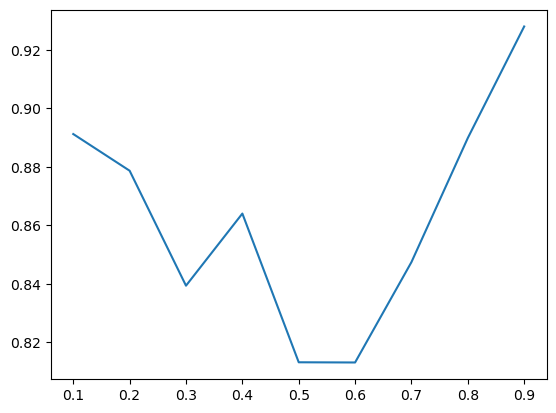

In [65]:
plt.plot(sims, mean_agr)

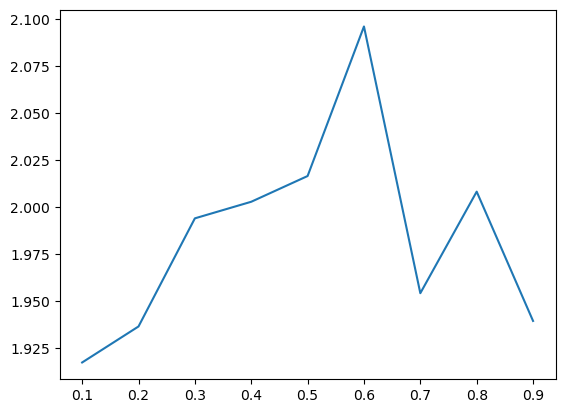

In [66]:
plt.plot(sims, mean_ce)